# 🛍️ Purchase Intent Prediction with Simulated Clickstream Data  
*Scoring product likelihood to be purchased using XGBoost*

This notebook simulates user-product interaction data (clicks and purchases) to train a **binary classification model** that predicts purchase intent.

We use product attributes (e.g., category, color, season, price), user persona types, and simulated click counts to learn patterns associated with higher conversion likelihood.

The model outputs a **purchase probability score** for each product-user pair, which is used to:
- 🎯 Prioritize products in promotional campaigns
- 📦 Inform inventory-aware promotion strategies in OmniRetail AI


## 📦 Imports & Path Setup

In [20]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier

# Paths Setup
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
RAW_DIR = os.path.join(BASE_DIR, "data", "raw")
MODEL_DIR = os.path.join(BASE_DIR, "models")
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")

STYLES_CSV = os.path.join(RAW_DIR, "styles.csv")

## 📄 Load and Clean Product Metadata

We load product metadata from the DeepFashion dataset and retain only rows with complete categorical fields.  
These fields will be used as input features for predicting purchase intent.

In [21]:
# Load raw metadata
df = pd.read_csv(STYLES_CSV, on_bad_lines='skip')

# Drop incomplete rows
df = df.dropna(subset=["id", "articleType", "baseColour", "season"])

print(f"✅ Loaded {len(df)} rows with complete product metadata.")
df.head()

✅ Loaded 41571 rows with complete product metadata.


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


## 💰 Simulate and Visualize Product Prices

Since DeepFashion doesn’t include price data, we simulate a realistic price distribution using a normal distribution:

- Mean price: ~\$50  
- Majority: \\$30–\\$80  
- Max cap: \$250 (to avoid outliers)


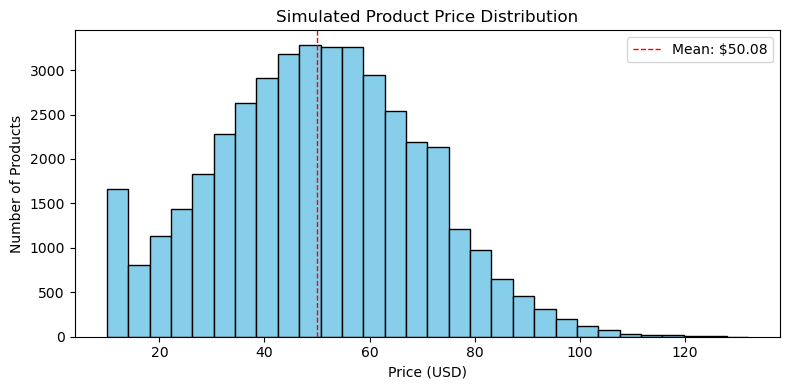

In [22]:
# Simulate prices
df["price"] = np.round(np.random.normal(loc=50, scale=20, size=len(df))).clip(10, 250)

# Plot distribution
plt.figure(figsize=(8, 4))
plt.hist(df["price"], bins=30, color="skyblue", edgecolor="black")
plt.axvline(df["price"].mean(), color="red", linestyle="dashed", linewidth=1, label=f"Mean: ${df['price'].mean():.2f}")
plt.title("Simulated Product Price Distribution")
plt.xlabel("Price (USD)")
plt.ylabel("Number of Products")
plt.legend()
plt.tight_layout()
plt.show()

## 👥 Simulate User Personas & Clickstream Behavior
In real-world recommendation systems, user segmentation is often based on historical behavior (e.g., clustering on session data).
Here, we simulate this by assigning randomly generated user personas to create synthetic clickstream data.

We simulate:

- 5,000 unique users

- 20,000 user–product interaction events (clicks)

- 3 user personas:

    - **Budget** — favors low-priced products

    - **Fashionista** — prefers seasonal trends

    - **Color Lover** — sensitive to product color

These personas will later influence simulated purchases, mimicking diverse decision patterns.

In [23]:
# Simulate 5,000 users and 20,000 user–product interactions
n_users = 5000
n_interactions = 20000

# Generate user-product pairs (clicks)
user_ids = np.random.randint(1, n_users + 1, size=n_interactions)
product_ids = np.random.choice(df['id'], size=n_interactions)

# Build interaction log (each row = one click)
interaction_df = pd.DataFrame({
    'user_id': user_ids,
    'product_id': product_ids,
    'clicked': 1
})

# Define 3 user types (personas)
user_profiles = ['budget', 'fashionista', 'color_lover']

# Assign one persona to each user (randomly)
user_map = {uid: np.random.choice(user_profiles) for uid in range(1, n_users + 1)}
interaction_df['user_type'] = interaction_df['user_id'].map(user_map)

interaction_df.head()

,user_id,product_id,clicked,user_type
0,3121,7198,1,color_lover
1,219,57335,1,fashionista
2,1810,18474,1,color_lover
3,3624,15681,1,fashionista
4,3894,59557,1,color_lover


## 🔁 Add Product Popularity Signal (Click Count)

In recommendation systems, product popularity is a powerful signal.
To simulate this, we compute how often each product has been clicked across all users — giving us a `click_count` feature.

Why it matters:

- Popular products tend to have higher purchase rates due to visibility or social proof.

- `click_count` becomes a numeric feature in our model to help capture this global interest.

In [24]:
# Count how many times each product was clicked
click_count = interaction_df['product_id'].value_counts().to_dict()

# Add a column to store each product's total clicks
interaction_df['click_count'] = interaction_df['product_id'].map(click_count)

interaction_df.head()

,user_id,product_id,clicked,user_type,click_count
0,3121,7198,1,color_lover,1
1,219,57335,1,fashionista,2
2,1810,18474,1,color_lover,2
3,3624,15681,1,fashionista,2
4,3894,59557,1,color_lover,1


## 🔗 Merge Product Metadata & Encode Categorical Features

To build our prediction model, we join product metadata (`articleType`, `baseColour`, `season`, `price`) with each user-product interaction. These fields come from the DeepFashion metadata and help capture item-level signals.

Then we apply label encoding to categorical columns so they can be used in our XGBoost model. This transforms values like `"Dresses"` → `0`, `"Jeans"` → `1`, etc.

In [25]:
# Rename to match interaction log for merging
df = df.rename(columns={'id': 'product_id'})

# Join product metadata to interaction log
merged = interaction_df.merge(df, on='product_id', how='left')

# Label encode all categorical fields
for col in ['articleType', 'baseColour', 'season', 'user_type']:
    merged[col] = LabelEncoder().fit_transform(merged[col])

# Preview enriched dataset
merged.head()

,user_id,product_id,clicked,user_type,click_count,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,price
0,3121,7198,1,1,1,Women,Apparel,Topwear,122,13,0,2011.0,Casual,Jealous 21 Women's Shimmery Flower Print Grey Top,7198.jpg,55.0
1,219,57335,1,2,2,Women,Apparel,Innerwear,13,44,3,2015.0,Casual,Amante White Bra BCSO01,57335.jpg,69.0
2,1810,18474,1,1,2,Men,Footwear,Shoes,19,44,2,2011.0,Casual,Puma Men Calcetto White Casual Shoes,18474.jpg,36.0
3,3624,15681,1,2,2,Men,Apparel,Bottomwear,126,15,0,2011.0,Casual,Highlander Men Classic Chinos Khaki Trousers,15681.jpg,56.0
4,3894,59557,1,1,1,Women,Accessories,Jewellery,3,11,2,2013.0,Casual,Lucera Gold Plated Bangle,59557.jpg,27.0


## 🧪 Simulate Purchases with Rule-Based Logic

To train a supervised model, we need both positive and negative labels (purchased vs. not purchased).
Since we don’t have real purchase records, we simulate them using **rule-based heuristics** grounded in our user personas.

We define a simple decision function that mimics user behavior:

- **Budget Shopper** is more likely to purchase if the price is below $50

- **Fashionista** prefers seasonally relevant items (e.g., Fall)

- **Color Lover** is drawn to products with their favorite colors

- **Popular Products** (high click count) have a slightly higher baseline conversion

Each condition increases the probability of a simulated purchase. We then apply a random draw to determine the final label.

In [26]:
# Define logic to simulate whether a user purchases a product after viewing it
def simulate_purchase(row):
    prob = 0.1  # Base probability: everyone has some chance to convert

    # Budget shopper more likely to buy cheaper items
    if row['user_type'] == 0 and row['price'] < 50:
        prob += 0.3

    # Fashionista prefers seasonal items (Fall = 2 in encoded labels)
    if row['user_type'] == 1 and row['season'] == 2:
        prob += 0.2

    # Color lover prefers top 3 colors (e.g., encoded as 0, 1, 2)
    if row['user_type'] == 2 and row['baseColour'] in [0, 1, 2]:
        prob += 0.2

    # Popular products get a slight boost
    if row['click_count'] > 30:
        prob += 0.1

    # Return 1 if a random draw falls below the computed probability
    return np.random.rand() < prob

# Apply simulation to generate purchase labels
merged['purchased'] = merged.apply(simulate_purchase, axis=1).astype(int)

merged.head()

,user_id,product_id,clicked,user_type,click_count,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,price,purchased
0,3121,7198,1,1,1,Women,Apparel,Topwear,122,13,0,2011.0,Casual,Jealous 21 Women's Shimmery Flower Print Grey Top,7198.jpg,55.0,0
1,219,57335,1,2,2,Women,Apparel,Innerwear,13,44,3,2015.0,Casual,Amante White Bra BCSO01,57335.jpg,69.0,0
2,1810,18474,1,1,2,Men,Footwear,Shoes,19,44,2,2011.0,Casual,Puma Men Calcetto White Casual Shoes,18474.jpg,36.0,0
3,3624,15681,1,2,2,Men,Apparel,Bottomwear,126,15,0,2011.0,Casual,Highlander Men Classic Chinos Khaki Trousers,15681.jpg,56.0,0
4,3894,59557,1,1,1,Women,Accessories,Jewellery,3,11,2,2013.0,Casual,Lucera Gold Plated Bangle,59557.jpg,27.0,0


## 🧠 Train Purchase Intent Classifier (XGBoost)

With simulated labels in place, we now train an XGBoost binary classifier to predict whether a user will purchase a given product.

The model learns from a combination of:

- **Product features**: `articleType`, `baseColour`, `season`, `price`

- **User profile**: `user_type`

- **Product popularity**: `click_count`

We split the dataset into an 80/20 train-test split and use **log loss** as the evaluation metric during training.

In [27]:
# Define input features for model training
features = ['articleType', 'baseColour', 'season', 'price', 'user_type', 'click_count']
X = merged[features]         # Feature matrix
y = merged['purchased']      # Target label (0 = no purchase, 1 = purchase)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train XGBoost classifier
model = XGBClassifier(
    n_estimators=100,             # Number of trees
    use_label_encoder=False,      # Avoid label encoding warning
    eval_metric='logloss'         # Use log loss for binary classification
)

model.fit(X_train, y_train)

/Users/letitiachang/anaconda3/envs/python101_2024/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:52:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## 📊 Evaluate Model Performance

We evaluate the model using:

- **Classification Report**: Provides precision, recall, F1-score, and support for both purchased and non-purchased cases.

- **AUC (Area Under the ROC Curve)**: Measures the model’s ability to distinguish between positive and negative classes. AUC is especially useful when the dataset is imbalanced, as it focuses on ranking predictions rather than raw accuracy.

In [28]:
# Predict class labels for the test set
y_pred = model.predict(X_test)

# Print classification metrics
print(classification_report(y_test, y_pred))

# Calculate AUC score using predicted probabilities for class 1 (purchase)
y_prob = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score: {auc_score:.2f}")

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      3223
           1       0.32      0.07      0.11       777

    accuracy                           0.79      4000
   macro avg       0.56      0.52      0.50      4000
weighted avg       0.72      0.79      0.73      4000

AUC Score: 0.68


## 💾 Save Trained Model and Predictions
After training, we:

- Use the model to assign a **purchase probability** to each product-user pair

- Export these scores to power downstream promotion and inventory strategies

- Save the trained XGBoost model for future reuse

In [29]:
# Add predicted purchase probabilities to the dataset
merged['purchase_prob'] = model.predict_proba(merged[features])[:, 1]

# Save product-level purchase probabilities
purchase_output_path = os.path.join(PROCESSED_DIR, "purchase_predictions.csv")
merged[['product_id', 'purchase_prob']].to_csv(purchase_output_path, index=False)
print(f"✅ Saved purchase probabilities to: {purchase_output_path}")

# Save trained XGBoost model
model_output_path = os.path.join(MODEL_DIR, "purchase_model.json")
model.save_model(model_output_path)
print(f"✅ Trained model saved to: {model_output_path}")

✅ Saved purchase probabilities to: /Users/letitiachang/Desktop/Projects/omni-retail-ai/data/processed/purchase_predictions.csv
✅ Trained model saved to: /Users/letitiachang/Desktop/Projects/omni-retail-ai/models/purchase_model.json


## ✅ Summary
- Simulated a clickstream dataset with 20,000 user–product interactions and behavioral personas (e.g., budget shoppers, trend-followers).

- Engineered features from product metadata (articleType, baseColour, season, price), user type, and click count.

- Used rule-based logic to simulate purchase behavior, mimicking real-world decision tendencies.

- Trained an XGBoost binary classifier to predict purchase intent.

- Achieved **AUC score of 0.68** — indicating moderate ability to rank likely purchases.

- Model shows high accuracy (79%) but struggles with minority class recall (purchase class), reflecting the dataset imbalance.

- Saved predicted purchase probabilities and the trained model for downstream inventory-aware promotion ranking.

➡️ Next step: use predicted purchase intent scores to prioritize products in promotional campaigns and balance against available inventory.